In [306]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,cauchy, rice
import cv2 as cv

In [88]:
filename = '../images/map_400_swaths_5_cm_res_org_method.csv'
map_org = np.loadtxt(filename, delimiter=',')

filename = '../images/map_400_swaths_5_cm_res_new_method.csv'
map_new = np.loadtxt(filename, delimiter=',')

filename = '../images/map_4890_swaths_10_cm_res_new_method.csv'
map = np.loadtxt(filename, delimiter=',')

In [5]:
plt.rcParams['figure.figsize'] = [20, 15]

<IPython.core.display.Javascript object>


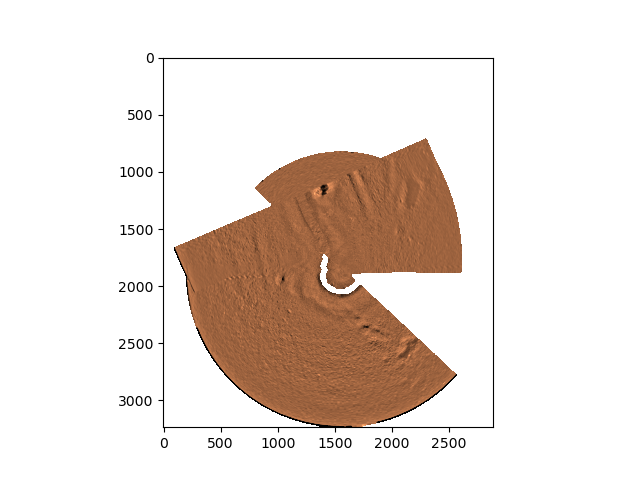

In [95]:
%matplotlib notebook
plt.imshow(map_org, cmap='copper', vmin=0.8, vmax=1.2, aspect='equal')
plt.show()

<IPython.core.display.Javascript object>


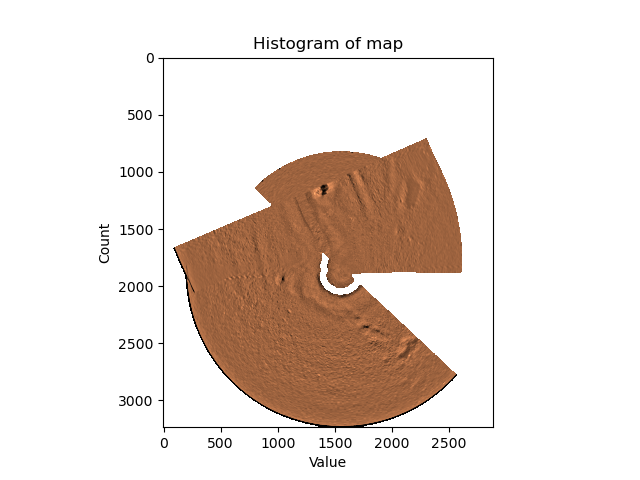

In [114]:
%matplotlib notebook
plt.imshow(map_new, cmap='copper', vmin=0.8, vmax=1.2, aspect='equal')
plt.show()

<IPython.core.display.Javascript object>


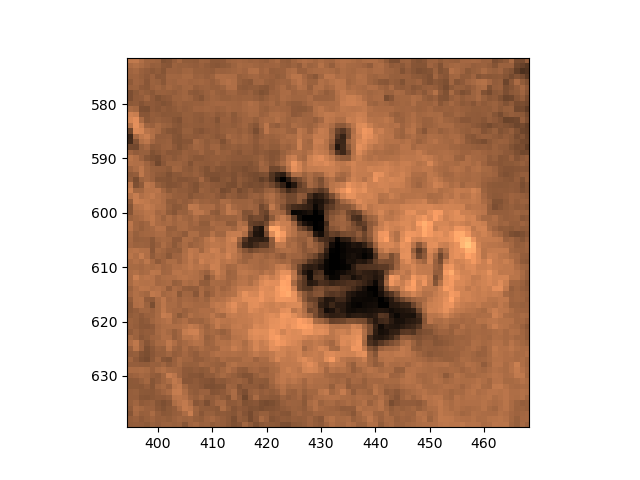

In [57]:
%matplotlib notebook
plt.imshow(map, cmap='copper', vmin=0.8, vmax=1.2, aspect='equal')
plt.show()

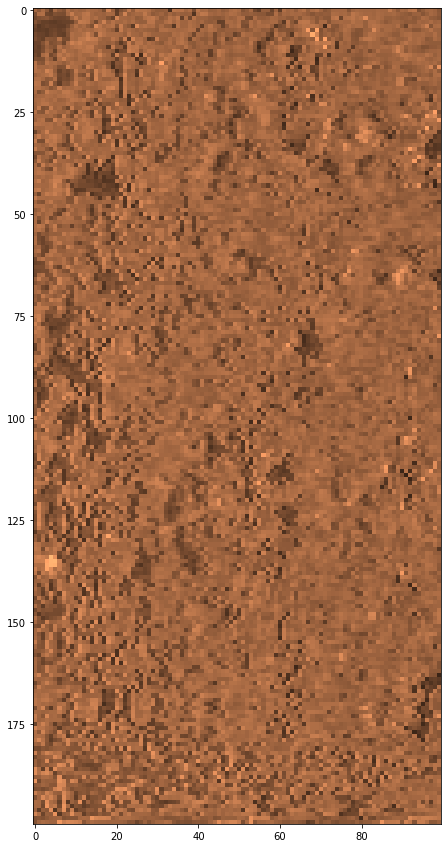

In [36]:
rows = range(450,550)
cols = range(400,600)

x_min = 500
x_max = 600
y_min = 200
y_max = 400

plt.imshow(map[y_min:y_max, x_min:x_max], cmap='copper', vmin=0.6, vmax=1.4)
plt.show()

<IPython.core.display.Javascript object>


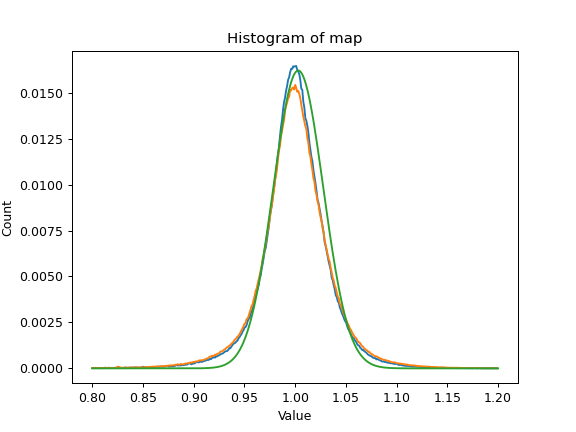

In [328]:
%matplotlib notebook

map_hist_org = map_org[~np.isnan(map_org)]
hist_org, edges_org = np.histogram(np.ravel(map_hist_org), bins=np.linspace(0.8, 1.2, 401))

map_hist_new = map_new[~np.isnan(map_new)]
hist_new, edges_new = np.histogram(np.ravel(map_hist_new), bins=np.linspace(0.8, 1.2, 401))

mu, sigma = norm.fit(map_hist_org)
sigma = 0.025
mu = 1
x = np.linspace(0.8, 1.2, 400)
y_norm = norm.pdf(x, loc=mu, scale=sigma) * np.diff(edges_org)[0]

median = np.median(map_hist_org)
scale = np.std(map_hist_org)
median = mu
scale = 0.020
y_cauchy = cauchy.pdf(x, loc=median, scale=scale) * np.diff(edges_org)[0]
y_rice = rice.pdf(x, 4.0, loc=0.9, scale=0.025) * np.diff(edges_org)[0]

plt.plot(edges_org[:-1], hist_org/len(map_hist_org), label='Histogram org')
plt.plot(edges_new[:-1], hist_new/len(map_hist_new), label='Histogram new')
# plt.plot(x, y_cauchy, label='Cauchy')
# plt.plot(x, y_norm, label='Gaussian')
# plt.plot(x, (0.5*y_cauchy + 0.5*y_norm), label='Rayleigh ratio')
plt.plot(x,y_rice)

# plt.plot(edges_new[:-1], hist_new.cumsum()/len(map_hist_new), label='Histogram cumsum')
    
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of map')
plt.show()

<IPython.core.display.Javascript object>


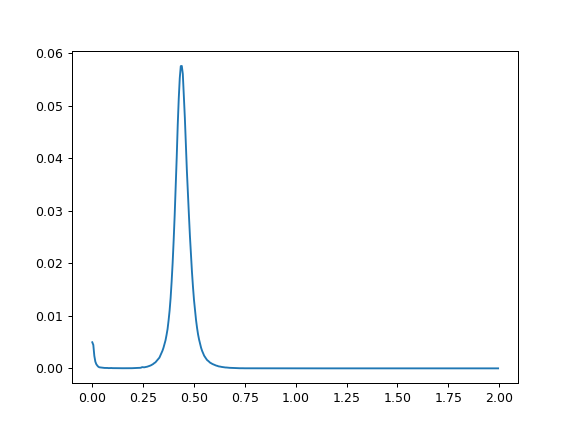

In [308]:
%matplotlib notebook

map_hist = map_new[~np.isnan(map_new)]
hist, edges = np.histogram(np.ravel(map_hist), bins=np.linspace(0.0, 2.0, 401))
cdf = hist.cumsum()

# Normalize cdf
cdf_normalized = cdf / cdf.max()

# Compute equalized image
equalized_image = np.interp(map_new.flatten(), edges[:-1], cdf_normalized)
equalized_image = equalized_image.reshape(map_new.shape) * 2

gain = 1000
gamma = 3
image = map_new / np.nanmax(map_new)
image = np.power(image, gamma)

#plt.imshow(image, cmap='copper', aspect='equal')

#plt.plot(edges[:-1], cdf_normalized, label='Histogram')

hist, edges = np.histogram(np.ravel(image[~np.isnan(image)]), bins=np.linspace(0.0, 2.0, 401))
plt.plot(edges[:-1], hist/len(image[~np.isnan(image)]), label='Histogram')
#plt.plot(edges[:-1], hist.cumsum()/len(equalized_image[~np.isnan(equalized_image)]))

In [178]:
def get_otsu_threshold(im, n_bins=256):

        flat_im = im.flatten()
        flat_im = flat_im[~np.isnan(flat_im)]
        hist, bins = np.histogram(flat_im, n_bins)
        
        total_pixels = im.shape[0] * im.shape[1]
        probs = hist / total_pixels
        
        best_thresh_ind = 0
        best_var = 0

        # plt.plot(hist)
        
        for i in range(n_bins):
            # Calculate probabilities and means of the two classes
            bg_prob = np.sum(probs[:i])
            fg_prob = np.sum(probs[i:])
            bg_mean = np.sum(np.arange(i) * probs[:i]) / bg_prob if bg_prob > 0 else 0
            fg_mean = np.sum(np.arange(i, n_bins) * probs[i:]) / fg_prob if fg_prob > 0 else 0
            
            var = bg_prob * fg_prob * (bg_mean - fg_mean)**2
            
            if var > best_var:
                best_thresh_ind = i
                best_var = var

        return bins[best_thresh_ind+1]

In [299]:
def clahe_enhancement(img, clip_limit=2.0, grid_size=(8, 8), n_bins=256):
    # Check if image is grayscale
    if len(img.shape) != 2:
        raise ValueError("Image must be grayscale.")

    # Pad image borders with NaN values to avoid artifacts from edge effects
    img = np.pad(img, 1, mode="constant", constant_values=np.nan)

    # Calculate image statistics for each grid
    height, width = img.shape
    dx, dy = grid_size
    step_x, step_y = int(np.ceil(width / dx)), int(np.ceil(height / dy))
    grid_shape = (step_y, step_x, dy, dx)
    grid_size = dy * dx

    # Calculate histogram and clip excess values in each grid
    hist, bin_edges = np.histogram(img[~np.isnan(img)], bins=n_bins, range=(0, 255))
    cdf = np.cumsum(hist)
    # cdf = np.concatenate(([0], cdf))
    excess = cdf - cdf[int(clip_limit * grid_size)]  # excess clipped values
    excess[excess < 0] = 0
    hist = np.clip(hist - excess, 0, 2)
    cdf = np.cumsum(hist)

    # Apply CLAHE to each grid
    out = np.empty(img.shape)
    for y in range(step_y):
        for x in range(step_x):
            gx, gy = x * dx, y * dy
            crop = img[gy+1:gy+dy+1, gx+1:gx+dx+1]
            crop_nan = np.isnan(crop)
            crop_nonnan = np.logical_not(crop_nan)
            #print(crop_nonnan.shape, gx, gx+dx)
            crop_nonnan_flat = crop[crop_nonnan].flatten()
            crop_nan_flat = crop_nan.flatten()
            hist_crop, _ = np.histogram(crop_nonnan_flat, bins=bin_edges)
            excess = hist_crop - clip_limit * grid_size
            excess[excess < 0] = 0
            hist_crop = np.clip(hist_crop - excess, 0, 2)
            cdf_crop = np.cumsum(hist_crop) / np.sum(hist_crop)
            cdf_crop = np.concatenate(([0], cdf_crop))
            crop_out = np.interp(crop_nonnan_flat, bin_edges, cdf_crop * 2)
            # print(crop_nonnan.shape, dx)
            out[gy+1:gy+dy+1, gx+1:gx+dx+1][crop_nonnan] = crop_out
            out[gy+1:gy+dy+1, gx+1:gx+dx+1][crop_nan] = np.nan

    # Remove border padding and return output image
    out = out[1:-1, 1:-1]
    return out.astype(np.uint8)

In [304]:
map_clahe = clahe_enhancement(map_new,0.05)

/tmp/ipykernel_345086/2582909537.py:40: RuntimeWarning: invalid value encountered in true_divide
  cdf_crop = np.cumsum(hist_crop) / np.sum(hist_crop)


<IPython.core.display.Javascript object>


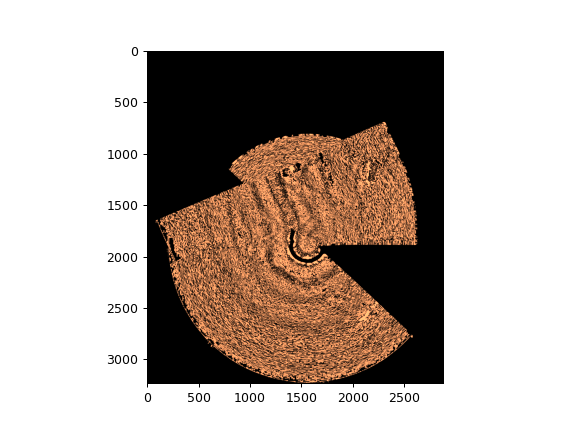

In [305]:
%matplotlib notebook

plt.imshow(map_clahe, cmap='copper', aspect='equal')

<IPython.core.display.Javascript object>


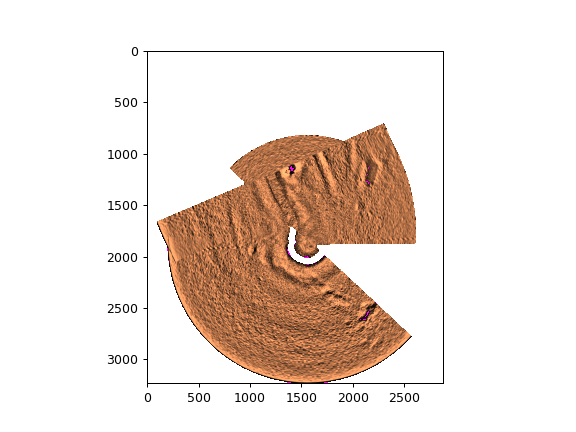

In [183]:
%matplotlib notebook

threshold = get_otsu_threshold(equalized_image, 401)

_retval, landmark_candidates = \
    cv.threshold(equalized_image, threshold, 1.0, cv.THRESH_BINARY_INV)

landmark_candidates = landmark_candidates.astype(np.float64)
landmark_candidates[landmark_candidates == 0.0] = np.nan

plt.imshow(equalized_image, cmap='copper', vmin=0, vmax=2, aspect='equal')
plt.imshow(landmark_candidates, cmap='spring')

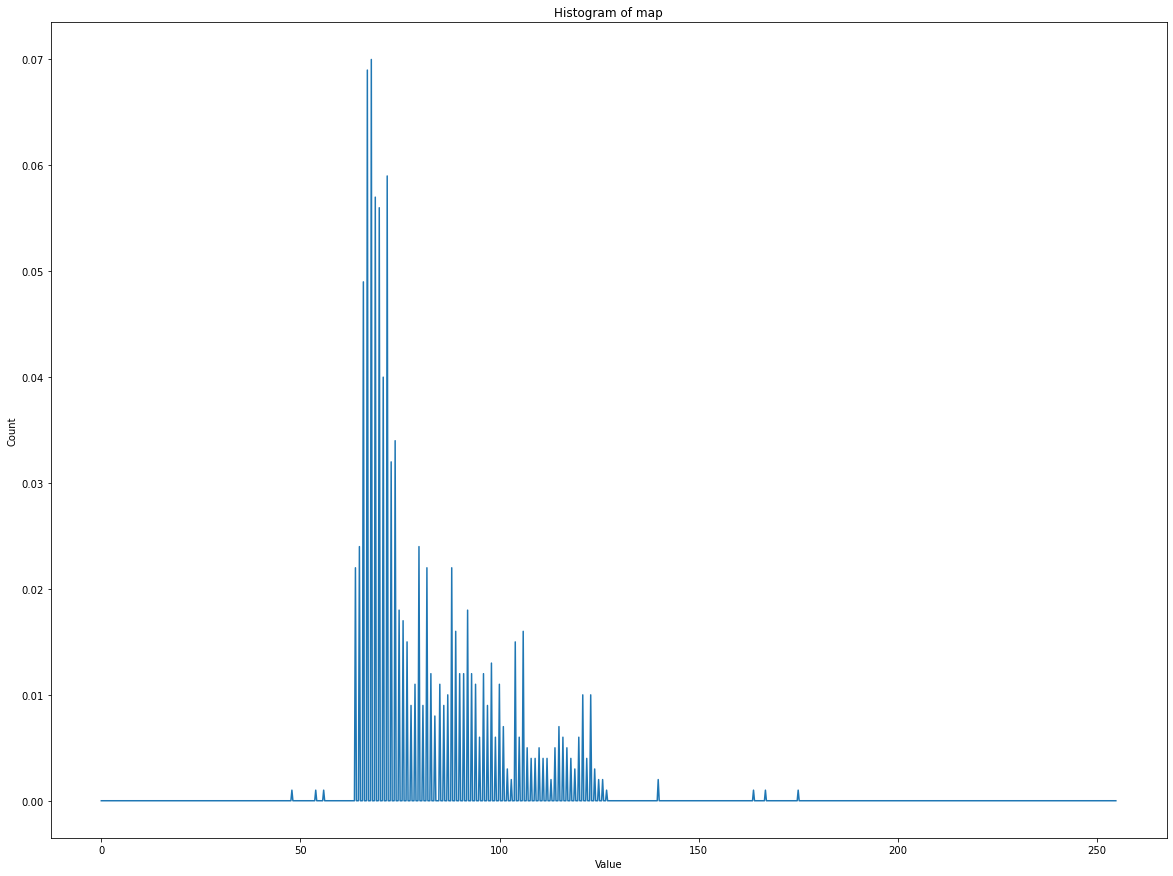

In [96]:
map = map_raw[1,1000:]
map_hist = map[~np.isnan(map)]

hist, edges = np.histogram(np.ravel(map_hist), bins=np.linspace(0, 255, 4*256))

plt.plot(edges[:-1], hist/len(map_hist), label='Histogram 2')


plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram of map')
plt.show()

In [106]:
image = map_new[~np.isnan(map_new)]
signal_power = np.sum(image ** 2)
noise_power = np.sum((image - np.mean(image)) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(snr)

20.112582413652902


In [103]:
image = map_org[~np.isnan(map_org)]
signal_power = np.sum(image ** 2)
noise_power = np.sum((image - np.mean(image)) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(snr)

22.2831107724226


In [113]:
image = map[~np.isnan(map)]
signal_power = np.sum(image ** 2)
noise_power = np.sum((image - np.mean(image)) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(snr)

34.92226765197814
